In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad, jacrev
from jax.lax import cond, scan
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, coords_2_strain_nn
from utils import train_colloc_parallel as train_colloc, init_params_nn, ff_nn, divergence, bd_forces, a1, a2, lr
from utils_hyperelasticity import NODE, init_layers, NODE_model_aniso, init_params_aniso, GOH_model, eval_Cauchy, eval_Cauchy_vmap, eval_P, eval_P_vmap
from utils_hyperelasticity import ThreeDElasticity
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, apply_bc_biax

from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

from PIL import Image, ImageFilter
from jaxinterp2d import interp2d

E_fun = vmap(lambda F: 0.5*(F.T@F - jnp.eye(2)))

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



In [17]:
with open('data/manu/stiff2_hetero.npy', 'rb') as f:
    x,y,F_hist,force = pickle.load(f)
elem_X = np.stack([x.T.flatten(),y.T.flatten()]).T

# we don't need to use all of that data
i1 = 10
i2 = 30
skip = 4
F_hist = F_hist[i1:i2:skip]
force = force[i1:i2:skip]

print(F_hist.mean(axis=1)[:,1,1])

[1.05544 1.07795 1.10065 1.12326 1.14587]


In [18]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = x.shape[1], x.shape[0]
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])

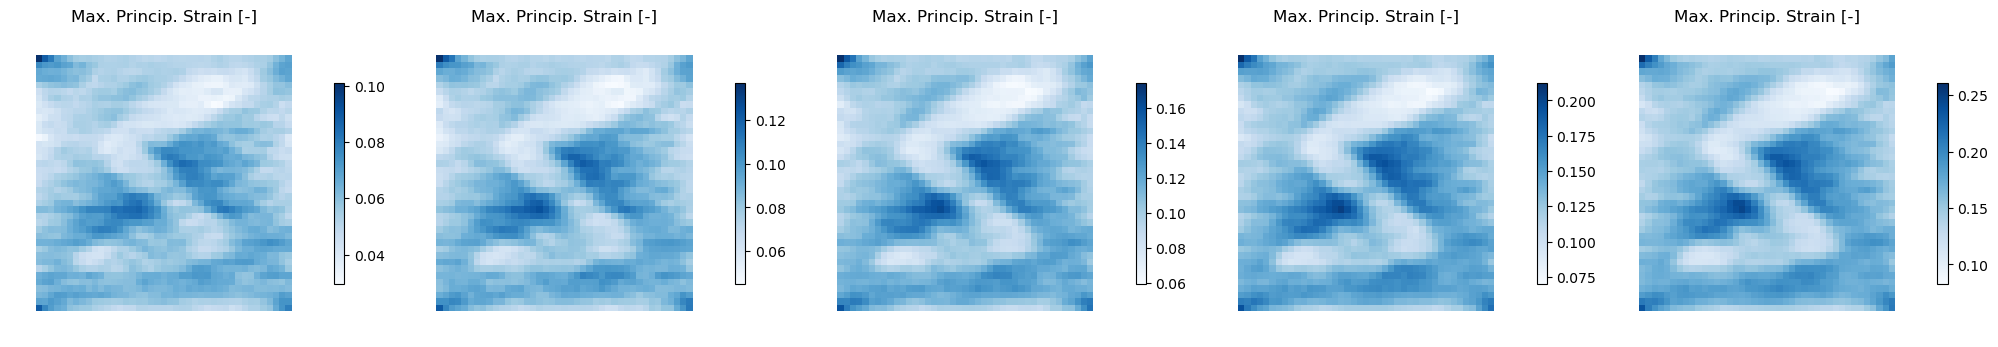

In [19]:
n_panels = 5
fig, axes = plt.subplots(1,n_panels,figsize=(5*n_panels,4))
strains = []
t_hist = np.arange(len(F_hist))
for i in range(len(F_hist)):
    F = F_hist[i]
    t = t_hist[i]
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    mps = np.maximum(E_11, E_22)
    strains.append(np.array([t*np.ones(len(F)), F[:,0,0], F[:,0,1], F[:,1,0], F[:,1,1]]))

    if i < n_panels:
        ax = axes[i]
        plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax, ec='None'); 

strains = np.hstack(strains)

### Coords_2_strain NN

In [54]:
# instead of using a 2D spline, use a NN to get the strain field for a given (x,y)
def loss_coords_2_strain(params, X, key):
    inp, out_gt = X[:,:3], X[:,3:] #inp: x,y,lmb and out_gt=eps_xx, eps_yy
    t = inp[:,2:3]
    out_pr = coords_2_strain_nn(inp, params)
    out_gt = out_gt/(t+1) #dividing by t+1 just for some regularization
    out_pr = out_pr/(t+1) #dividing by t+1 just for some regularization
    return jnp.mean((out_pr-out_gt)**2)

n_ff = 40 # 10 cosines and 10 sines in the fourier features
n_inp = 2 # x, y
ff_params = np.random.normal(size=n_inp*n_ff).reshape([n_inp,n_ff])*0.5
nn_layers = [2*n_ff+1,40,40,4]
nn_params = init_params_nn(nn_layers, key)
coord_2_strain_params = [ff_params, nn_params]

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(coord_2_strain_params)

X = np.vstack([elem_X]*len(F_hist))
inp = np.hstack([X, strains.T])
coord_2_strain_params, train_loss, _ = train(loss_coords_2_strain, inp, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=1000, batch_size=10000)

it 1000, train loss = 7.859165e-05
it 2000, train loss = 3.276569e-05
it 3000, train loss = 1.880000e-05
it 4000, train loss = 1.273697e-05
it 5000, train loss = 9.949849e-06
it 6000, train loss = 8.632864e-06
it 7000, train loss = 7.848690e-06
it 8000, train loss = 7.225221e-06
it 9000, train loss = 6.482235e-06
it 10000, train loss = 6.225498e-06
it 11000, train loss = 6.443593e-06
it 12000, train loss = 6.262367e-06
it 13000, train loss = 5.952556e-06
it 14000, train loss = 5.143313e-06
it 15000, train loss = 4.576663e-06
it 16000, train loss = 5.014020e-06
it 17000, train loss = 4.541077e-06
it 18000, train loss = 4.318930e-06
it 19000, train loss = 4.642275e-06
it 20000, train loss = 4.520570e-06
it 21000, train loss = 4.443421e-06
it 22000, train loss = 4.198528e-06
it 23000, train loss = 4.437029e-06
it 24000, train loss = 4.941648e-06
it 25000, train loss = 4.221528e-06
it 26000, train loss = 6.255178e-06
it 27000, train loss = 3.924348e-06
it 28000, train loss = 4.456720e-06
i

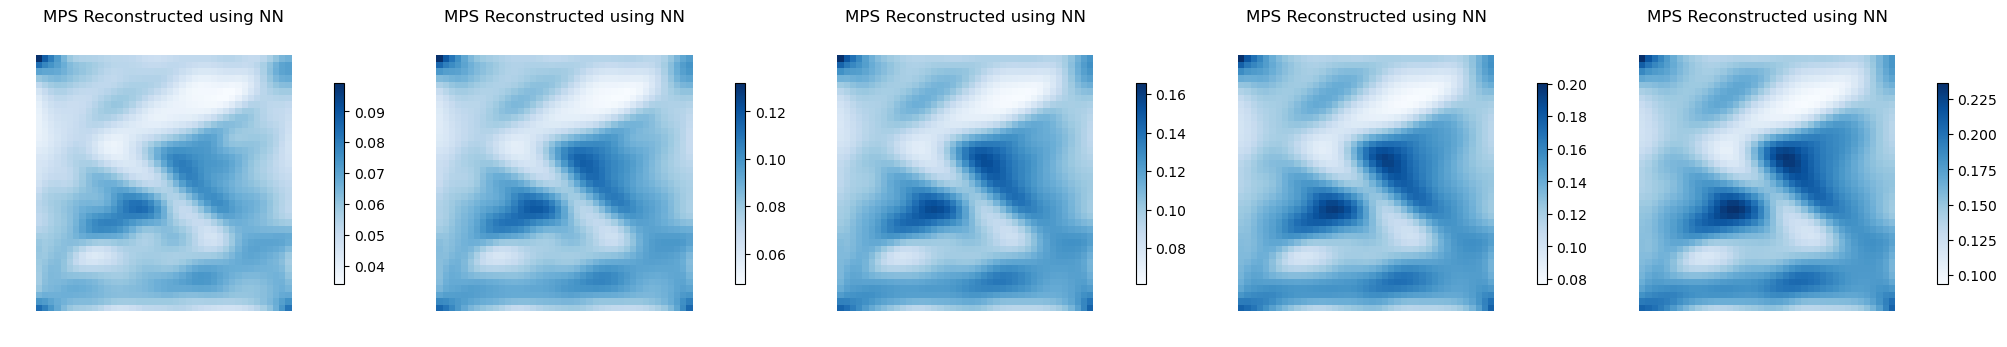

In [55]:
fig, axes = plt.subplots(1,5,figsize=(25,4))
for t in t_hist:
    aux = np.hstack([elem_X, t*np.ones_like(elem_X[:,:1])])
    F_xx, F_xy, F_yx, F_yy = coords_2_strain_nn(aux, coord_2_strain_params).T
    F = np.stack([F_xx, F_xy, F_yx, F_yy]).T.reshape([-1,2,2])
    
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T
    mps = np.maximum(E_11, E_22)

    if t < 5:
        plotmesh(mesh.cells, mesh.points, mps, title='MPS Reconstructed using NN', ax=axes[t], ec='None'); 

In [56]:
# identify the boundaries
rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(mesh.cells):
    if any([mesh.points[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([mesh.points[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([mesh.points[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([mesh.points[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

Force_y = force
Force_x = force*0.0

# get the center points of the elements
rgt_bd_X = elem_X[rgt_bd_elems]
top_bd_X = elem_X[top_bd_elems]
lft_bd_X = elem_X[lft_bd_elems]
bot_bd_X = elem_X[bot_bd_elems]
bd_X = rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X

In [57]:
Force_x = jnp.array(Force_x)
Force_y = jnp.array(Force_y)

In [58]:
# Homogenize the strains
F_xx_mean = np.mean(F_hist[:,:,0,0], axis=1)
F_xy_mean = np.mean(F_hist[:,:,0,1], axis=1)
F_yx_mean = np.mean(F_hist[:,:,1,0], axis=1)
F_yy_mean = np.mean(F_hist[:,:,1,1], axis=1)

P_xx_mean = Force_x/len(rgt_bd_elems)
P_yy_mean = Force_y/len(top_bd_elems)
inputs = np.array([F_xx_mean, F_xy_mean, F_yx_mean, F_yy_mean, P_xx_mean, P_yy_mean]).T

n_neurons = 4
# Define the loss function for when training all params
@jit
def loss_stress(params, x, key):
    model = NODE_model_aniso(params)
    F_xx, F_xy, F_yx, F_yy, P_xx_gt, P_yy_gt = x.T
    P = eval_P_vmap(F_xx, F_xy, F_yx, F_yy, model)
    P_xx_pr, P_yy_pr = P[:,0,0], P[:,1,1]
    return np.mean((P_xx_pr-P_xx_gt)**2+(P_yy_pr-P_yy_gt)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params = init_params_aniso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(node_params)

# Train
node_params, train_loss, _ = train(loss_stress, inputs, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=1000)

it 1000, train loss = 9.621164e-04
it 2000, train loss = 4.804365e-04
it 3000, train loss = 3.412407e-04
it 4000, train loss = 2.896164e-04
it 5000, train loss = 2.576419e-04
it 6000, train loss = 2.287139e-04
it 7000, train loss = 2.008243e-04
it 8000, train loss = 1.760816e-04
it 9000, train loss = 1.574017e-04
it 10000, train loss = 1.442957e-04
it 11000, train loss = 1.340101e-04
it 12000, train loss = 1.258794e-04
it 13000, train loss = 1.195336e-04
it 14000, train loss = 1.144536e-04
it 15000, train loss = 1.101642e-04
it 16000, train loss = 1.070231e-04
it 17000, train loss = 1.053033e-04
it 18000, train loss = 1.040445e-04
it 19000, train loss = 1.031210e-04
it 20000, train loss = 1.024423e-04
it 21000, train loss = 1.019485e-04
it 22000, train loss = 1.015751e-04
it 23000, train loss = 1.013040e-04
it 24000, train loss = 1.011038e-04
it 25000, train loss = 1.009558e-04
it 26000, train loss = 1.008463e-04
it 27000, train loss = 1.007649e-04
it 28000, train loss = 1.007044e-04
i

In [59]:
mymodel = NODE_model_aniso(node_params)
P = eval_P_vmap(F_xx_mean, F_xy_mean, F_yx_mean, F_yy_mean, mymodel)
P_xx_pr, P_yy_pr = P[:,0,0], P[:,1,1]
print('gt P_xx & P_yy: ', P_xx_mean, P_yy_mean)
print('pr P_xx & P_yy: ', P_xx_pr, P_yy_pr)

gt P_xx & P_yy:  [0. 0. 0. 0. 0.] [0.06064 0.07768 0.0933  0.1086  0.12284]
pr P_xx & P_yy:  [0.00208 0.00284 0.00353 0.00409 0.00464] [0.04696 0.06732 0.08865 0.11073 0.13373]


In [60]:
# Fit a function Λ that maps x,y ∈ [0,1] to the individual-specific parameters of this NODE with a maximum variance of, say, 1%
phi, unravel = ravel_pytree(node_params)
n_phi = len(phi)

# ff_params = coord_2_strain_params[0]
# ff_nn2 = lambda x, nn_params: ff_nn(x, [ff_params, nn_params])
def loss_Lambda(params, inp, key):
    out_pr = ff_nn(inp, params)
    return jnp.mean((out_pr-phi)**2)

n_ff = 40
ff_params = np.random.normal(size=2*n_ff).reshape([2,n_ff])
nn_layers = [2*n_ff,40,40,n_phi]
nn_params = init_params_nn(nn_layers, key)
Lambda_params = [ff_params, nn_params]
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

inp = np.array(np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))).reshape([2,-1]).T
Lambda_params, train_loss, _ = train(loss_Lambda, inp, get_params, opt_update, opt_state, key, nIter = 5000, print_freq=1000)

it 1000, train loss = 1.431174e-05
it 2000, train loss = 7.916159e-06
it 3000, train loss = 5.607966e-06
it 4000, train loss = 4.048767e-06
it 5000, train loss = 2.802224e-06


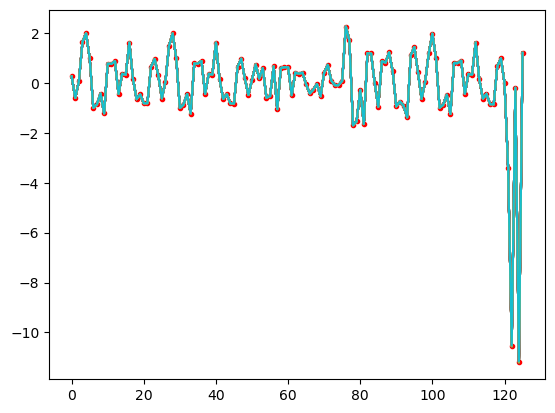

In [61]:
fig, ax = plt.subplots()
ax.plot(phi, 'r.-')
for y in np.linspace(0,1,4):
    for x in np.linspace(0,1,10):
        params = ff_nn(np.array([x,y]).reshape([1,-1]), Lambda_params)
        ax.plot(params[0])

In [62]:
with open('params/AM_stiff2_pre.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Force_x, Force_y, strains,
                 bd_X, F_hist, t_hist], f)

## 2. Retrain

In [63]:
with open('params/AM_stiff2_pre.npy', 'rb') as f:
    coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Force_x, Force_y, strains, \
                 bd_X, F_hist, t_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

In [64]:
# # Train
# a1 = 10000

# def loss_div(Lambda_params, XYt_colloc):
#     Div_x, Div_y = divergence(Lambda_params, XYt_colloc, coord_2_strain_params, NODE_w_unravel)
#     loss_Div = a1*(Div_x**2 + Div_y**2)
#     return loss_Div
# def loss_force(Lambda_params, XYt_colloc):
#     def bd_forces_loss(_, t):
#         F_rgt, F_top, F_lft, F_bot = bd_forces(Lambda_params, t, bd_X, coord_2_strain_params, NODE_w_unravel)
#         Fx = Force_x[jnp.array(t, int)]
#         Fy = Force_y[jnp.array(t, int)]
#         return None, a2*((F_rgt-Fx)**2 + (F_top-Fy)**2 + (F_lft-Fx)**2 + (F_bot-Fy)**2)
#     loss_F = jnp.mean(scan(bd_forces_loss, init=None, xs=t_hist)[1])
#     return loss_F

# @jit
# def loss(Lambda_params, XYt_colloc):
#     return loss_div(Lambda_params, XYt_colloc) + loss_force(Lambda_params, XYt_colloc)

# lr = optimizers.exponential_decay(1e-4, 1000, 0.9)
# sharding = PositionalSharding(jax.devices()).reshape(n_cores, 1)
# opt_init, opt_update, get_params = optimizers.adam(lr) 
# opt_state = opt_init(Lambda_params)

# node_X_ext = jnp.hstack([mesh.points, t_hist[-1]*np.ones_like(mesh.points[:,:1])])
# metric1 = lambda params, X:  bd_forces(params, t_hist[-1], bd_X, coord_2_strain_params, NODE_w_unravel)
# metric2 = lambda params, X: divergence(params, node_X_ext, coord_2_strain_params, NODE_w_unravel)

# Lambda_params, val_loss, metrics = train_colloc(loss, [mesh.points, t_hist], get_params, opt_update, opt_state, 
#                                             key, sharding, None, nIter = 40000, print_freq=1000, metric_fns = [loss_div, loss_force], batch_size=5000)

# with open('params/AM_stiff2_post.npy', 'wb') as f:
#     pickle.dump([mesh, elem_X, strains, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics, t_hist], f)

In [65]:
# Train
a1 = 10000
@jit
def loss(Lambda_params, XYt_colloc):
    Div_x, Div_y = divergence(Lambda_params, XYt_colloc, coord_2_strain_params, NODE_w_unravel)
    loss_Div = a1*(Div_x**2 + Div_y**2)

    def bd_forces_loss(_, t):
        F_rgt, F_top, F_lft, F_bot = bd_forces(Lambda_params, t, bd_X, coord_2_strain_params, NODE_w_unravel)
        Fx = Force_x[jnp.array(t, int)]
        Fy = Force_y[jnp.array(t, int)]
        return None, a2*((F_rgt-Fx)**2 + (F_top-Fy)**2 + (F_lft-Fx)**2 + (F_bot-Fy)**2)
    loss_F = jnp.mean(scan(bd_forces_loss, init=None, xs=t_hist)[1])
    # loss_F = 0.0
    
    return loss_Div + loss_F

lr = 1e-4
sharding = PositionalSharding(jax.devices()).reshape(n_cores, 1)
opt_init, opt_update, get_params = optimizers.adam(lr) 
opt_state = opt_init(Lambda_params)

node_X_ext = jnp.hstack([mesh.points, t_hist[-1]*np.ones_like(mesh.points[:,:1])])
metric1 = lambda params, X:  bd_forces(params, t_hist[-1], bd_X, coord_2_strain_params, NODE_w_unravel)
metric2 = lambda params, X: divergence(params, node_X_ext, coord_2_strain_params, NODE_w_unravel)

Lambda_params, val_loss, metrics = train_colloc(loss, [mesh.points, t_hist], get_params, opt_update, opt_state, 
                                            key, sharding, 'cross', nIter = 100000, print_freq=1000, batch_size=1000)

with open('params/AM_stiff2_post.npy', 'wb') as f:
    pickle.dump([mesh, elem_X, strains, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics, t_hist], f)

it 1, val loss = 7.092918e+00
it 1001, val loss = 1.156067e+00
it 2001, val loss = 2.576537e+00
it 3001, val loss = 2.215090e+00
it 4001, val loss = 8.470720e-01
it 5001, val loss = 3.192107e+00
it 6001, val loss = 2.010792e+00
it 7001, val loss = 2.245964e+00
it 8001, val loss = 9.024575e-01
it 9001, val loss = 1.062523e+00
it 10001, val loss = 1.552226e+00
it 11001, val loss = 1.073672e+00
it 12001, val loss = 6.877500e-01
it 13001, val loss = 6.516312e-01
it 14001, val loss = 9.751526e-01
it 15001, val loss = 3.726904e+00
it 16001, val loss = 8.380234e-01
it 17001, val loss = 8.309406e-01
it 18001, val loss = 5.147075e-01
it 19001, val loss = 1.082890e+00
it 20001, val loss = 8.077864e-01
it 21001, val loss = 1.048701e+00
it 22001, val loss = 1.092065e+00
it 23001, val loss = 1.121021e+00
it 24001, val loss = 1.862672e+00
it 25001, val loss = 7.362249e-01
it 26001, val loss = 1.038480e+00
it 27001, val loss = 8.675324e-01
it 28001, val loss = 6.102563e-01
it 29001, val loss = 2.0227

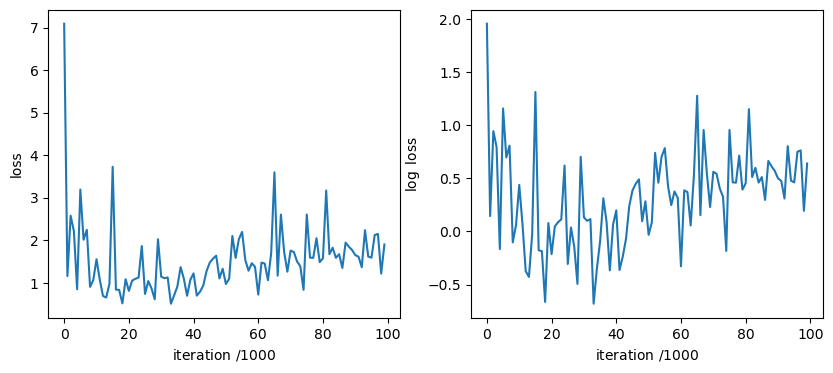

In [66]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(val_loss)
ax[1].plot(np.log(val_loss))

ax[0].set(xlabel='iteration $/1000$', ylabel='loss')
ax[1].set(xlabel='iteration $/1000$', ylabel='$\log$ loss'); 

## 3. Test

In [67]:
with open('params/AM_stiff2_post.npy', 'rb') as f:
    mesh, elem_X, strains, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics, t_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

In [68]:
cell_type = get_meshio_cell_type('QUAD4')

Nx, Ny = 50, 50
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh2 = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])
elem_X2 = mesh2.points[mesh2.cells].mean(axis=1)

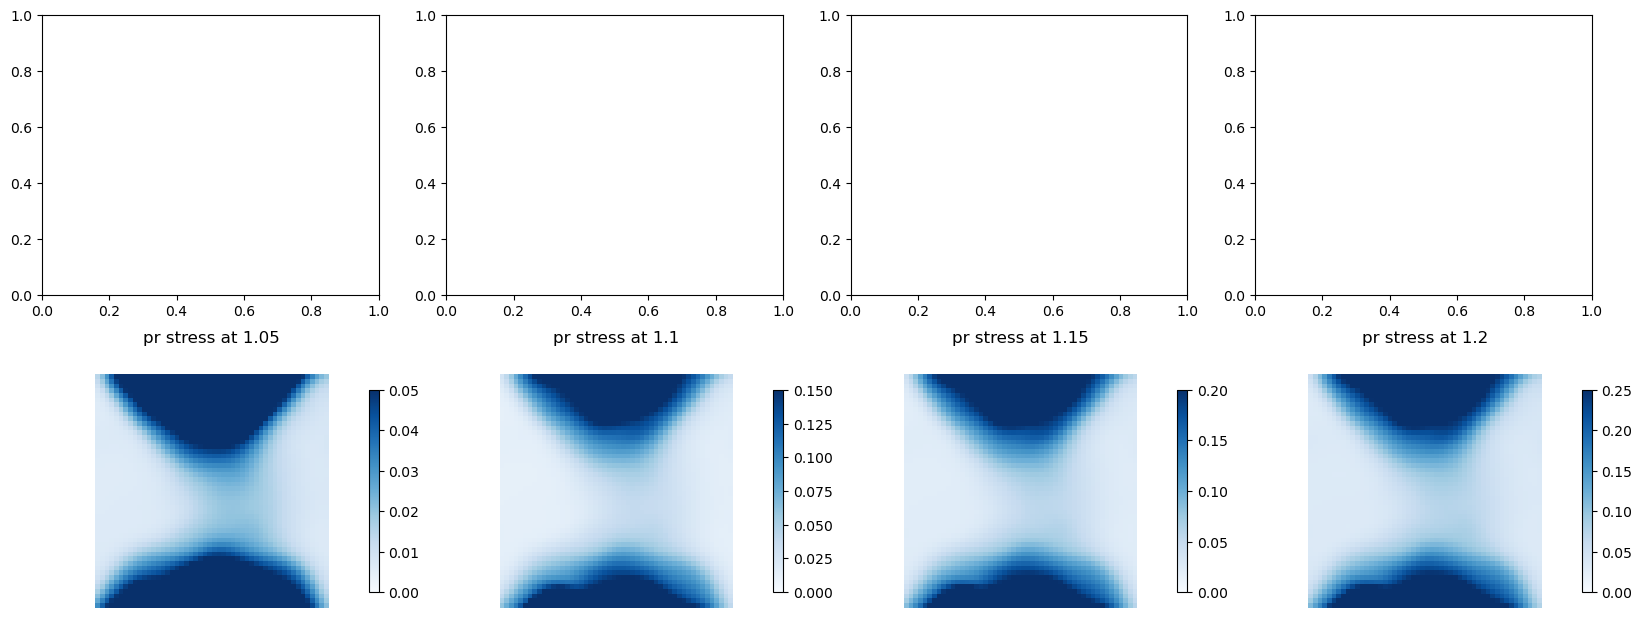

In [73]:
# Stiffness across the domain
fig, axes = plt.subplots(2,4,figsize=(20,8))
lmb_hist = [1.05, 1.1, 1.15, 1.2]

extents = [[0.0, 0.05],
           [0.0, 0.15],
           [0.0, 0.2],
           [0.0, 0.25]]
for lmb, ax, extent in zip(lmb_hist, axes.T, extents):
    ugrad = jnp.array([[lmb-1.0, 0.0], [0.0, lmb-1.0]])

    # params_gt = []
    # for xy in elem_X:
    #     params_gt.append(coords_2_params_gt(xy))
    # params_gt = np.array(params_gt)
    params_pr = ff_nn(elem_X2, Lambda_params)

    # c_elem_gt = []
    c_elem_pr = []
    # for params_gt_i, params_pr_i in zip(params_gt, params_pr):
    for params_pr_i in params_pr:
        # c_elem_gt.append(ThreeDElasticity(GOH_model).ugrad_2_P(ugrad, params_gt_i, 2)[0,0])
        c_elem_pr.append(ThreeDElasticity(NODE_w_unravel).ugrad_2_P(ugrad, params_pr_i, 2)[0,0])

    # plotmesh(mesh.cells, mesh.points, c_elem_gt, title='gt stress at {}'.format(str(lmb)), ax=ax[0]); 
    # extent = [np.min(c_elem_gt), np.max(c_elem_gt)]

    # if extent[0] > np.min(c_elem_pr) and extent[1] < np.max(c_elem_pr):
    #     extend='both'
    # elif extent[0] > np.min(c_elem_pr):
    #     extend='min'
    # elif extent[1] < np.max(c_elem_pr):
    #     extend='max'
    plotmesh(mesh2.cells, mesh2.points, c_elem_pr, title='pr stress at {}'.format(str(lmb)), ax=ax[1], ec='None', extent=extent); 

In [4]:
P_vmap = vmap(ThreeDElasticity(NODE_w_unravel).ugrad_2_P, in_axes=(0, 0, None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: ThreeDElasticity(NODE_w_unravel).ugrad_2_P(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [5]:
params_vec = []
for x, y in elem_X:
    Lambda_inp = np.array([x,y]).reshape([-1,2])
    phi = ff_nn(Lambda_inp, Lambda_params).flatten()
    params_vec.append(phi)
params_vec = jnp.array(params_vec).reshape([len(params_vec),1,-1])
params_vec = jnp.repeat(params_vec, axis=1, repeats=4)

In [6]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist = []
node_x_hist = []
P_hist = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    P = P_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist.append(F)
    node_x_hist.append(node_x)
    P_hist.append(P)
node_x_hist = np.array(node_x_hist)
F_hist = np.array(F_hist)
P_hist = np.array(P_hist)

[01-29 12:02:18][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-29 12:02:18][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[01-29 12:02:18][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[01-29 12:02:19][DEBUG] jax_fem: Done pre-computations, took 0.3462047576904297 [s]
[01-29 12:02:19][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[01-29 12:02:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-29 12:02:19][DEBUG] jax_fem: Start timing
[01-29 12:02:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-29 12:02:22][DEBUG] jax_fem: Function split_and_compute_cell took 2.7130 seconds
[01-29 12:02:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-29 12:02:22][DEBUG] jax_fem: Linear guess solve...
[01-29 12:02:22][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[01-29 12:02:22][DEBUG] jax_fem: PETSc 

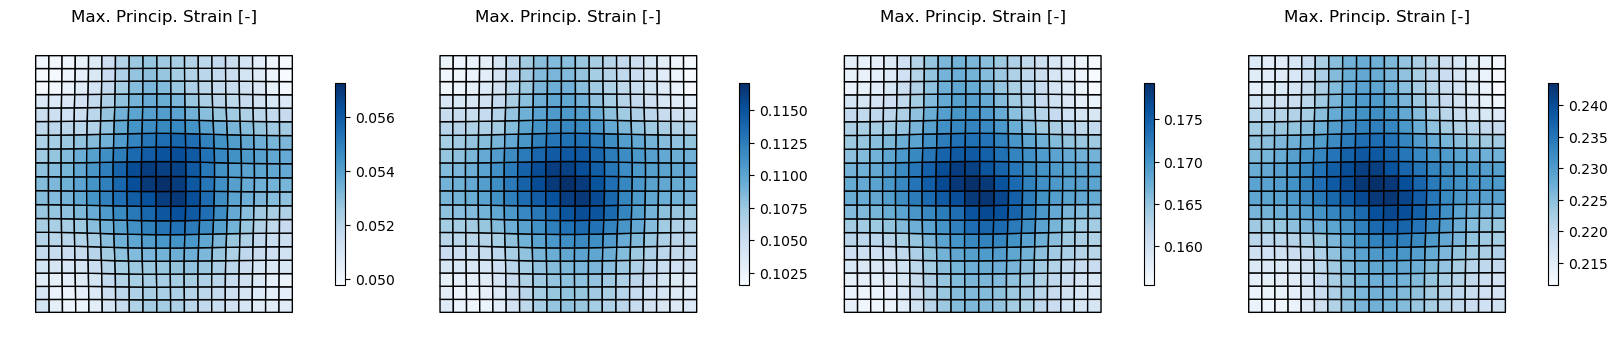

In [8]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, node_x, F, ax in zip(t_hist, node_x_hist, F_hist, axes):
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    mps = np.maximum(E_11, E_22)
    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 